# Ускорение и оптимальные методы (20 баллов)

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

seed = 57
rng = np.random.default_rng(seed)

## Основная часть (10 баллов)

Рассмотрим задачу минимизации эмпирического риска (Emperical Risk Minimization):

$$
\min_{x \in \mathbb{R}^d} \left[ f(x) = \frac{1}{n} \sum_{i=1}^n \ell \left(g(x, a_i), b_i \right) + \frac{\lambda}{2} \| x \|^2_2 \right],
$$

где:
- $\ell(\cdot, \cdot) : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ — функция потерь на одном элементе;
- $g(\cdot, \cdot) : \mathbb{R}^{d} \times \mathbb{R}^{d} \to \mathbb{R}$ — модель;
- $x \in \mathbb{R}^d$ — вектор параметров модели;
- $\{ a_i \}_{i = 1}^n \in \mathbb{R}^{d}$ — векторы-признаков $\left(\text{при транспонировании образуют в совокупности строки дата-матрицы}~ A \in \mathbb{R}^{n \times d}\right)$;
- $\{ b_i \}_{i = 1}^n \in \mathbb{R}$ — целевые значения $\left(\text{в совокупности образующие таргет-вектор }b \in \mathbb{R}^n\right)$;
- $\lambda > 0$ — параметр регуляризации.

В данной домашней работе предлагается рассмотреть в качестве
- модели $g(\cdot, \cdot)$ комбинацию _линейной_ и _логистической_ (или _сигмоидной_) функций:

$$
g(x, a_i) = \frac{1}{1 + \exp \left[- \langle x, a_i \rangle\right]};
$$

- функции потерь на одном элементе $\ell(\cdot, \cdot)$ _кросс-энтропию_:

$$
\ell(g(x, a_i), b_i) = -b_i \log \left[g(x, a_i)\right] - (1 - b_i) \log \left[1 -  g(x, a_i)\right].
$$

__Задача 1.__ Прежде чем мы перейдем к оптимизационным методам, вычислим все основные константы, а также произведем небольшой препроцессинг данных.


__а) (0.5 балла)__ Докажите, что градиент фунции $f(x)$ равен

$$
\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x.
$$

$$f(x) = \frac{1}{n} \sum_{i=1}^n \ell \left(g(x, a_i), b_i \right) + \frac{\lambda}{2} \| x \|^2_2$$

Функция $f:\mathbb{R}^d \to \mathbb{R}$, значит $D(f(x))[h] = ⟨\nabla f(x); h⟩$

Для краткости буду замнять $g(x, a_i)$ на g

$$D(f(x))[h] = \frac{1}{n} \sum_{i=1}^n D(\ell \left(g, b_i \right))[h] + \frac{\lambda}{2} D( ∥x∥^2_2)[h]$$

$$D(\ell \left(g, b_i \right))[h] = D(-b_i \log (g) - (1 - b_i) \log (1 -  g)[h] = $$
$$= -b_i \frac{1}{g}D(g))[h] + (1-b_i)\frac{1}{1 -  g}D(g)[h] = $$
$$= D(g)[h](-b_i \frac{1}{g} + (1-b_i)\frac{1}{1 -  g}) = $$
$$= D(g)[h]([-b_i(1-g) + (1-b_i)g]\frac{1}{(1 -  g)g}) = $$
$$= D(g)[h](\frac{g - b_i}{g(1 -  g)}) = $$

............................................................


g есть сигмоида от $y = \langle x, a_i \rangle$
$$g(x, a_i) = \sigma (y) $$

$$\sigma '(y) = \sigma(y) (1 - \sigma(y)) \langle a_i, h \rangle$$


...............................................................
$$= \frac{g(1-g)(g - b_i) \langle a_i, h \rangle}{g(1 -  g)} = (g - b_i) \langle a_i, h \rangle$$

Теперь рассмотрим

$$D( ∥x∥^2_2)[h] = D(⟨x, x⟩)[h] = 2⟨x, h⟩$$

В итоге:

$$\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \frac{\lambda}{2}2x = $$
$$\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x $$

__б) (1 балл)__ Докажите, что константа Липшица градиента $L$ может быть оценена как:

$$
L \geq \frac{1}{4n} \lambda_{\max} \left[A^\top A \right] + \lambda,
$$

где $A$ — дата-матрица, определенная в начале работы.

$$∥\nabla f(x) - \nabla f(y)∥ \leq L ∥x - y∥$$ для любых $x, y \in \mathbb{R}^d$

$$\nabla f(x) - \nabla f(y) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i - g(y, a_i) + b_i) a_i + \lambda (x - y) = $$

$$  = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - g(y, a_i)) a_i + \lambda (x - y) = $$

По неравенству треугольника:

$$ \|\nabla f(x) - \nabla f(y)\| \leq \frac{1}{n} \| \sum_{i=1}^n (g(x, a_i) - g(y, a_i)) a_i\| + \lambda \|x - y\|$$

По теореме о среднем: $f(b) - f(a) \leq f'(c)(b - a)$, для любых $a, b$ из области определения $с \in (a, b)$.

Оценим производную g (она же сигмоида):
$$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$
Маскимум достигается при $x = 0, \sigma(0) = \frac{1}{2}, \sigma'(0) = \frac{1}{4}$

$$g(x, a_i) - g(y, a_i) \leq \frac{1}{4} ⟨(x - y), a_i⟩$$

$$\| (g(x, a_i) - g(y, a_i)) a_i \| \leq \frac{1}{4}  \|⟨(x - y), a_i⟩ a_i \| $$


$A^T A(x - y) = (\sum_{i=1}^n(a_i a_i^T))(x - y) = \sum_{i=1}^n ⟨(x - y), a_i⟩a_i$, что в точности является правой частью прошлого выражения.

В итоге:

$$ \|\sum_{i=1}^n (g(x, a_i) - g(y, a_i)) a_i \| \leq \frac{1}{4}  \|A^T A(x - y)\| \leq \frac{1}{4} \lambda_{max}(A^T A) \|(x - y)\|$$

$$ \|\nabla f(x) - \nabla f(y)\| \leq \frac{1}{n} \frac{1}{4} \lambda_{max}(A^T A) \|(x - y)\| + \lambda \|x - y\|$$

Отсюда:

$$\frac{1}{n} \frac{1}{4} \lambda_{max}(A^T A) \|(x - y)\| + \lambda \|x - y\| \geq (\frac{1}{4n}\lambda_{max}(A^T A) + \lambda) \|x - y\|$$

$$L \geq (\frac{1}{4n}\lambda_{max}(A^T A) + \lambda)$$





__в) (0.5 балл)__ Докажите, что гессиан функции $f(x)$ равен

$$
\nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n g(x, a_i)(1 - g(x, a_i)) a_i a_i^\top + \lambda I_d.
$$

$$\nabla f(x) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i) - b_i) a_i + \lambda x $$

$$\nabla^2f(x) = \nabla(\nabla f(x)) = \frac{1}{n} \sum_{i=1}^n (\nabla g(x, a_i)\cdot a_i)a_i^T + \lambda \nabla(x) $$

$$\nabla^2f(x) = \nabla(\nabla f(x)) = \frac{1}{n} \sum_{i=1}^n (g(x, a_i)(1-g(x, a_i)) a_i a_i^T) + \lambda I_d $$

__г) (1  балл)__ Докажите, что константа сильной выпуклости $\mu$ может быть оценена как:

$$
\mu \leq \lambda,
$$

где $A$ — дата-матрица, определенная в начале работы.

Функция является $\mu$-сильно выпуклой тогда и только тогда, когда для любого $x \in \mathbb{R}^d$ верно $\nabla^2 f(x)\succeq \mu I$.

Это означает, что $$\frac{1}{n} \sum_{i=1}^n (g(x, a_i)(1-g(x, a_i)) a_i a_i^T) + (\lambda - \mu) I_d$$
положительно полуопределенная матрица (здесь $\lambda$ - коэффициент регуляризации), т.е. все ее собственные значения неотрицательны.

$g(x, a_i)(1-g(x, a_i)$ - неотрицательная величина, не превосходящая $\frac{1}{4}$, значит матрица

$$\frac{1}{n} \sum_{i=1}^n (g(x, a_i)(1-g(x, a_i)) a_i a_i^T)$$  положительно полуопределена

Хотим, чтобы и $(\lambda - \mu) I_d$ была положительно полуопределена, для этого достаточно потребовать, чтобы $\lambda \geq \mu$

__д)__ В качестве дата-матрицы $A$ и целевого вектора $b$ рассмотрим данные из датасета [_mushrooms_](https://github.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/blob/ПМИ_осень_2025/Datasets/mushrooms.txt). Ниже представлена функция загрузки датасета.

In [2]:
url = "https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt"
!wget -O mushrooms.txt "$url"

--2025-10-09 16:55:37--  https://raw.githubusercontent.com/BRAIn-Lab-teaching/OPTIMIZATION-METHODS-COURSE/%D0%9F%D0%9C%D0%98_%D0%BE%D1%81%D0%B5%D0%BD%D1%8C_2025/Datasets/mushrooms.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879712 (859K) [text/plain]
Saving to: ‘mushrooms.txt’

mushrooms.txt       100%[===================>] 859.09K  --.-KB/s    in 0.05s   

2025-10-09 16:55:37 (16.3 MB/s) - ‘mushrooms.txt’ saved [879712/879712]



In [3]:
from sklearn.datasets import load_svmlight_file

#файл должен лежать в той же деректории, что и notebook
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
A, b = data[0].toarray(), data[1]

# Необходимое линейное преобразование, которое меняет изначальные метки классов на 0 и 1
b = b - 1

In [4]:
A.shape

(8124, 112)

__e) (0.1  балла)__ C помощью функции ```train_test_split``` разделите датасет в отношение 4 к 1 (обучающая выборка должна быть в 4 раза больше, чем тестовая). Поставьте параметр ```random_state = 57```. В дальнейшем мы будем валидировать процесс обучения на тестовой выборке.

In [5]:
A_train, A_test, b_train, b_test = train_test_split(A, b, test_size = 0.2, random_state=seed)

__ж) (0.1  балла)__ Для обучающей части $A_{train}$, $b_{train}$ оцените константы $L$ и $\mu$, положив равенство в полученной ранее оценке. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.

In [6]:
AA = A_train.T @ A_train
eigenvalues = np.linalg.eigvals(AA)

L = eigenvalues.max() / (4 * A_train.shape[0])
mu = L / 1000
lambda_val = L / 1000

assert math.isclose(L, 2.586914976545057,  rel_tol=1e-6),  "Константа L-гладкости найдена неверно"
assert math.isclose(mu, 0.002586914976545057, rel_tol=1e-6),  "Константа регуляризации найдена неверно"

/tmp/ipython-input-3695786963.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  assert math.isclose(L, 2.586914976545057,  rel_tol=1e-6),  "Константа L-гладкости найдена неверно"
/tmp/ipython-input-3695786963.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  assert math.isclose(mu, 0.002586914976545057, rel_tol=1e-6),  "Константа регуляризации найдена неверно"


__з) (0.3  балла)__ Дополните функции подсчета сигмоиды, кросс-энтропии и градиента оптимизируемой функции. При этом $A$, $b$, $\lambda$ необходимо подавать в качестве параметра, чтобы была возможность их менять.

In [7]:
def sigmoid(x):
    """
    Вычисляет сигмоидную функцию.

    Параметры:
        x (np.array): Входное значение.

    Возвращает:
        sigmoid (np.array) Значение сигмоидной функции для входных данных.
    """
    return 1 / (1 + np.exp(-x))


def loss(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет значение функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели.
        A (np.array): Матрица признаков обучающей выборки.
        b (np.array): Вектор меток обучающей выборки.
        lambda_value (float): Параметр регуляризации.

    Возвращает:
        loss (float): Значение функции потерь.
    """

    n = len(b)
    sigm = sigmoid(A @ x)
    loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
    reg = (lambda_value / 2) * np.sum(x**2)
    return loss_val + reg


def grad(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет градиент функции потерь.

    Параметры:
        x (np.array): Вектор параметров модели.
        A (np.array): Матрица признаков обучающей выборки.
        b (np.array): Вектор меток обучающей выборки.
        lambda_value (float): Параметр регуляризации.

    Возвращает:
        grad (np.array): Градиент функции потерь.
    """
    n = len(b)
    grad = (A.T @ (sigmoid(A @ x) - b)) / n + lambda_value * x
    return grad

__Задача 2.__ Теперь, когда мы закончили с препроцессингом и реализацией основных функций, перейдем к ускоренным методам.

__a) (1.5 балла)__ Реализуйте метод тяжелого шарика.

**Псевдокод алгоритма**

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$.
- Параметр момента $\{ \tau_k \}_{k=0} \in [0, 1]$.
- Начальная точка $x^0 = x^{-1} \in \mathbb{R}^d$.
- Максимальное число итераций $K$.

---

$k$_-ая итерация_:

   $$x^{k+1} = x^k - \gamma_k \nabla f \left(x^k\right) + \tau_k \left(x^k - x^{k-1}\right)$$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\| \nabla f\left(x^k\right) \|_2 < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

In [8]:
def criterion(x, A=A_train, b=b_train, lambda_value=L/1000):
    """
    Вычисляет критерий остановки.

    Параметры:
        x (np.array): Текущая точка
        A (np.array): Матрица признаков
        b (np.array): Вектор меток
        lambda_value (float): Параметр регуляризации

    Возвращает:
        norm (float): Норма градиента
    """
    gradient = grad(x, A, b, lambda_value)
    return np.linalg.norm(gradient)

In [9]:
def heavy_ball(A, b, lambda_value, grad, criterion, x_0, eps, max_iter, **params):
    """
    Реализация метода тяжелого шарика.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'](k) : шаг на k-ой итерации
            params['tau'](k) : моментум на k-ой итерации

    Возвращает:
        x_k : Найденное решение
        values : Список значений x_k на каждой итерации
        errors : Список значений критерия сходимости на каждой итерации
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    values.append(x_k)
    x_k_prev = np.copy(x_0)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):
        gradient = grad(x_k, A, b, lambda_value)
        gamma_k = params['gamma'](k)
        tau_k = params['tau'](k)
        x_k_new = x_k - gamma_k * gradient + tau_k * (x_k - x_k_prev)
        x_k_prev = x_k
        x_k = x_k_new
        values.append(x_k_new)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

Запустите метод тяжелого шарика на обучающей выборке ERM. Для этого используйте следующие значение параметров:

- Положите шаг равным $\frac{1}{L}$;
- Рассмотрите моментум `tau` = $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$, а также моментумы; $[0.8\tau, 0.9\tau, 0.95\tau, 1.05\tau, 1.2\tau]$;
- Стартовую точку $x^0$ одинакова для всего задания, ее генерация приложена ниже;
- Положите максимальное число итераций равным $10^3$;
- Значение критерия остановки положите равным $10^{-8}$;

In [10]:
x_0 = rng.random(A_train.shape[1])
gamma_func = lambda k: 1 / L
tau = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
tau_coeff = [0.8, 0.9, 0.95, 1, 1.05, 1.2]
max_iter = int(1e3)
eps_criterion = 1e-8

In [11]:
errors = []
x_find = []
for c in tau_coeff:
  x_k, _, error = heavy_ball(A_train, b_train, L/1000, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_func, tau=lambda k: c * tau)
  errors.append(error)
  x_find.append(x_k)

  3%|▎         | 30/1000 [00:00<00:10, 93.13it/s]/tmp/ipython-input-2388429868.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 1000/1000 [00:13<00:00, 76.47it/s]


In [ ]:
def plot_heavy_ball(errors, tau_coeff, mu, L, K):
  iter = range(len(errors))

  plt.figure(figsize=(12, 9))
  for err, coeff in zip(errors, tau_coeff):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для tau с коэффициентом: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных tau')
  plt.grid(True, alpha=0.3)
  plt.legend()

Постройте сравнительный график график.

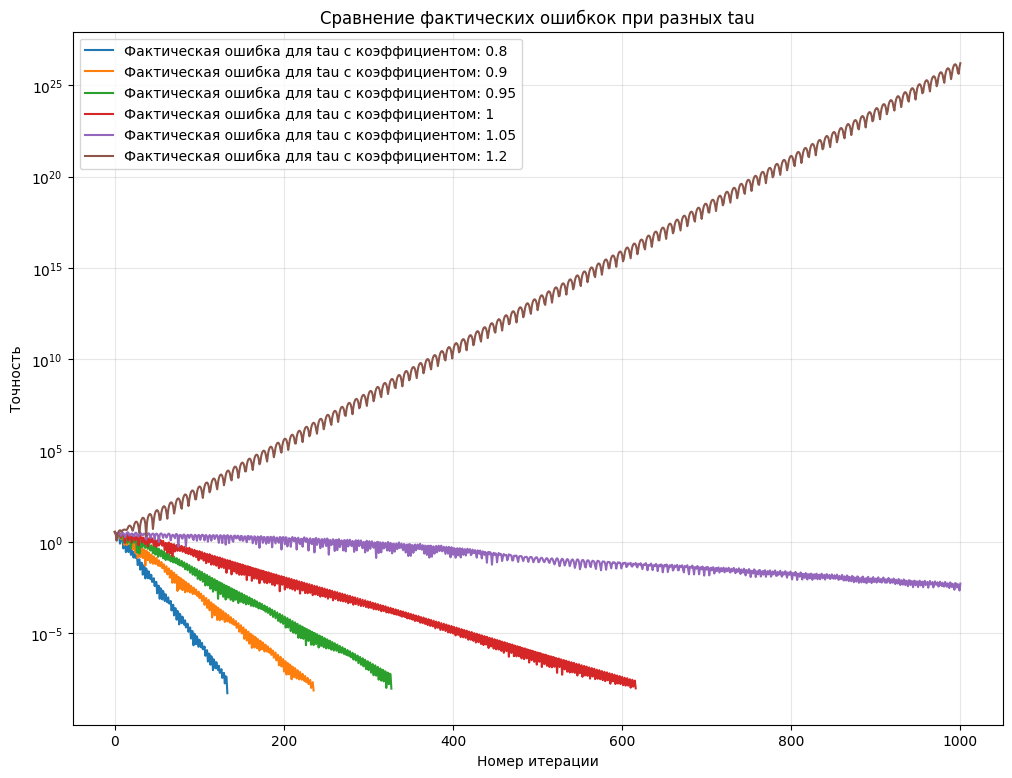

In [ ]:
plot_heavy_ball(errors, tau_coeff, mu, L, max_iter)

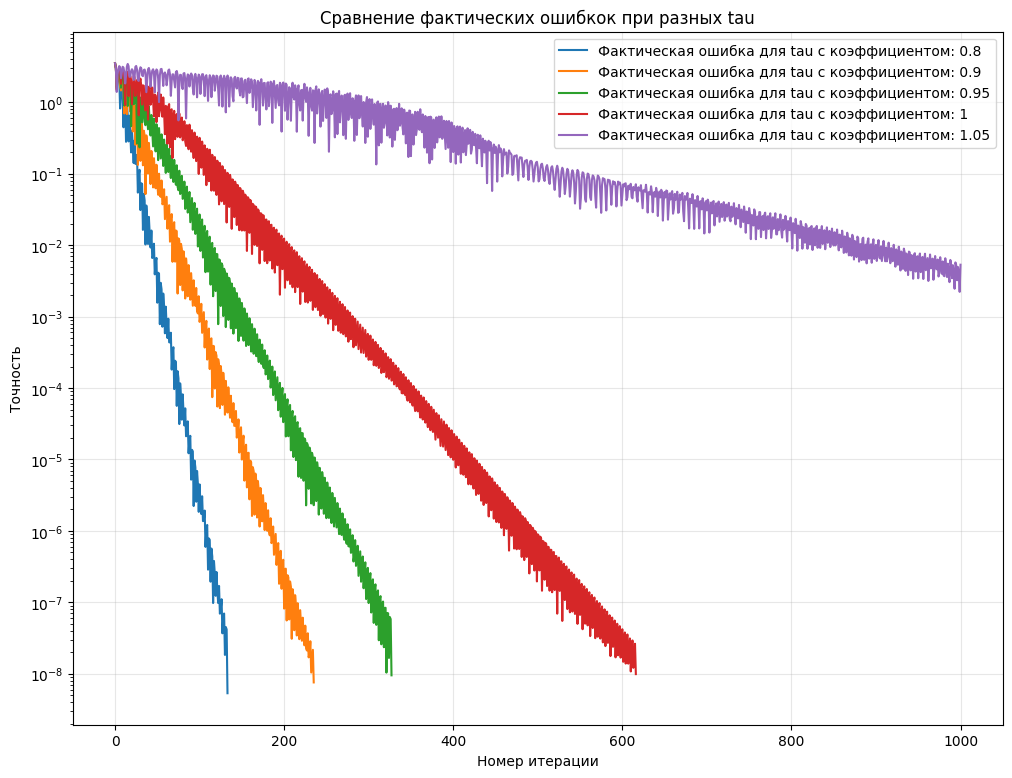

In [ ]:
plot_heavy_ball(errors[:-1], tau_coeff[:-1], mu, L, max_iter)

__б) (1 балл)__ Постройте сравнительный график, только теперь значение моментума будут зависеть от номера итерации. Сравните сходимости при
- $\tau = \frac{k}{k + 20}$;
- $\tau = \frac{k}{k + 10}$;
- $\tau = \frac{k}{k + 5}$;
- $\tau = \frac{k}{k + 1}$;
- Наилучший $\tau = const$.

In [ ]:
tau_functions = {
    "k/k + 20": lambda k: k/(k + 20),
    "k/k + 10": lambda k: k/(k + 10),
    "k/k + 5": lambda k: k/(k + 5),
    "k/k + 1": lambda k: k/(k + 1),
    "const 0.8 tau": lambda k: 0.8 * tau,
}

In [ ]:
def plot_heavy_ball_depends_step_tau(errors, tau_coeff, mu, L, K):
  iter = range(len(errors))

  plt.figure(figsize=(12, 9))
  for err, coeff in zip(errors, tau_coeff):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для tau: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных tau, зависящих от номера итерации')
  plt.grid(True, alpha=0.3)
  plt.legend()

In [ ]:
errors_depends_tau = []
for func in tau_functions:
  _, _, error = heavy_ball(A_train, b_train, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_func, tau=tau_functions[func])
  errors_depends_tau.append(error)

 13%|█▎        | 132/1000 [00:01<00:11, 74.22it/s]


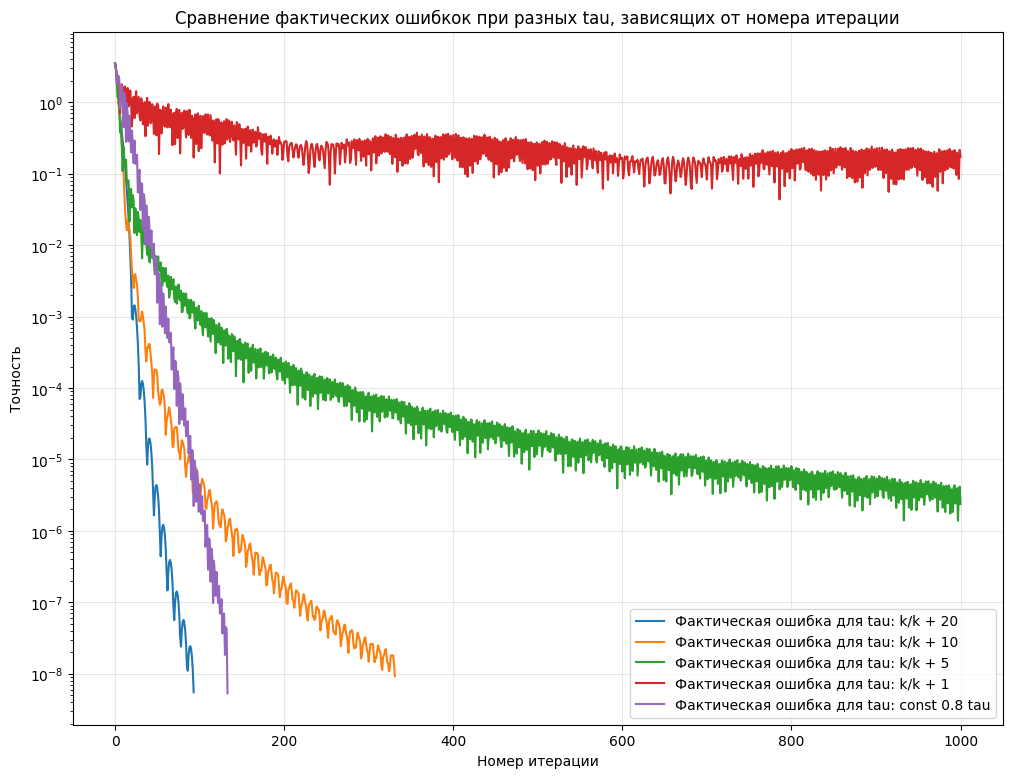

In [ ]:
plot_heavy_ball_depends_step_tau(errors_depends_tau, tau_functions.keys(), mu, L, max_iter)

In [ ]:
best_tau = tau_functions["k/k + 20"]

__в) (1 балл)__ Сравните метод тяжелого шарика с обычным градиентным спуском. Для этого реализуйте метод градиентного спуска, а сравнения проведите для лучшего значение моментума в методе тяжелого шарика со следующими значениями шагов (для каждого из методов):

- $\gamma_k = \frac{1}{2L}$,

- $\gamma_k = \frac{1}{L}$,

- $\gamma_k = \frac{2}{L}$,

- $\gamma_k = \frac{2}{\mu + L}$.



In [ ]:
gamma_functions = {
    "1/2L": lambda k: 1/(2*L),
    "1/L": lambda k: 1/L,
    "2/L": lambda k: 2/L,
    "2/μ+L": lambda k: 2/(mu + L)
}

In [ ]:
def gradient_descent(A, b, lambda_value, grad, criterion, x_0, eps, max_iter, **params):
    """
    Реализация градиентного спуска.

    Параметры:
        A (np.array): Матрица признаков.
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'] : шаг на k-ой итерации

    Возвращает:
        x_k (np.array) : Найденное решение
        values (list) : Список значений x_k на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    values.append(x_k)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):
        x_k = x_k - params['gamma'](k) * grad(x_k, A, b, lambda_value)
        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

In [ ]:
def plot_heavy_ball_vs_grad_desc(errors_hb, errors_gd, gamma_coeff, mu, L):
  colors = ['#FF0055', '#00FF88', '#0088FF', '#FFAA00']

  plt.figure(figsize=(12, 9))
  for err_hb, err_gd, coeff, col in zip(errors_hb, errors_gd, gamma_coeff, colors):
    plt.semilogy(range(len(err_hb)), err_hb, color=col, label=f'Фактическая ошибка для heavy ball c шагом: {coeff}')
    plt.semilogy(range(len(err_gd)), err_gd, "--", color=col, label=f'Фактическая ошибка для град спуска c шагом: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных шагах gamma для градиентного спуска и метода тяжелого шарика')
  plt.grid(True, alpha=0.3)
  plt.legend()

In [ ]:
errors_hb = []
errors_gd = []
for func in gamma_functions:
  _, _, error_hb = heavy_ball(A_train, b_train, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_functions[func], tau=best_tau)
  errors_hb.append(error_hb)

  _, _, error_gd = gradient_descent(A_train, b_train, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_functions[func])
  errors_gd.append(error_gd)

 23%|██▎       | 234/1000 [00:03<00:10, 69.89it/s]


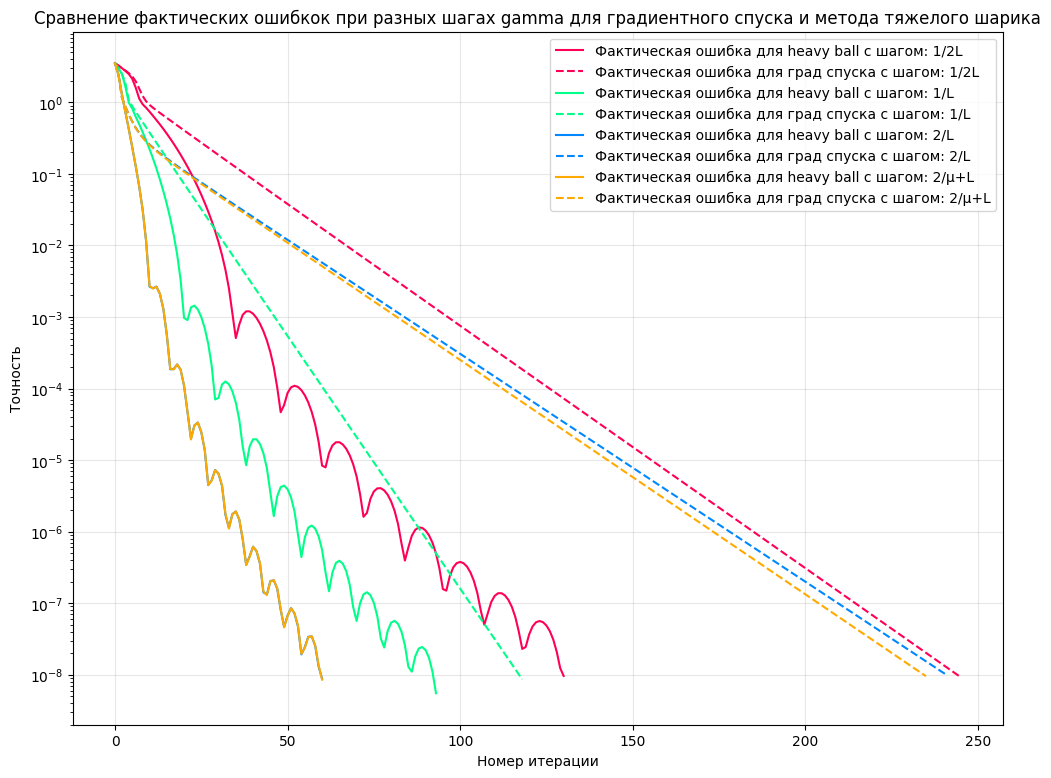

In [ ]:
plot_heavy_ball_vs_grad_desc(errors_hb, errors_gd, gamma_functions.keys(), mu, L)

__г) (1.5 балла)__ Реализуйте ускоренный градиентный метод.

**Псевдокод алгоритма**

---

_Инициализация:_

- Размер шага $\{ \gamma_k \}_{k=0} > 0$
- Параметр момента $\{ \tau_k \}_{k=0} \in [0, 1]$
- Начальная точка $x^0 = x^{-1} \in \mathbb{R}^d$
- Максимальное число итераций $K$

---

$k$_-ая итерация_:

1. Обновить точку для следующего градиента:
   $$y^k = x^k + \tau_k \left(x^k - x^{k - 1} \right)$$

2. Сделать шаг градиентного спуска:
   $$x^{k+1} = y^k - \gamma_k \nabla f \left(y^k \right)$$

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$ или $\| \nabla f \left(x^k\right) \| < \varepsilon$

---

_Выход:_
- Полученное значение $x^K$

In [ ]:
def NAG(A, b, lambda_value, grad, criterion, x_0, eps, max_iter, **params):
    """
    Реализация метода ускоренного градиента Нестерова.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        grad (Callable): Функция вычисления градиента в точке
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params : Именованные гиперпараметры метода
            params['gamma'](k) : функция шага на k-ой итерации
            params['tau'](k) : функция момента на k-ой итерации

    Возвращает:
        x_k (np.array) : Найденное решение
        values (list) : Список значений x_k на каждой итерации
        errors (list) : Список значений критерия сходимости на каждой итерации
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    x_k_old = np.copy(x_0)
    values.append(x_k)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):

        y_k = x_k + params['tau'](k)*(x_k - x_k_old)
        x_new = y_k - params['gamma'](k) * grad(y_k, A, b, lambda_value)
        x_k_old = x_k
        x_k = x_new
        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

Сравните его с методом тяжёлого шарика при тех же значениях моментума, что и в пункте __а)__.

In [ ]:
errors_hb = []
errors_nag = []
for c in tau_coeff:
  x_k, _, error_hb = heavy_ball(A_train, b_train, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_func, tau=lambda k: c * tau)
  errors_hb.append(error_hb)

  x_k, _, error_nag = NAG(A_train, b_train, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_func, tau=lambda k: c * tau)
  errors_nag.append(error_nag)

  6%|▌         | 61/1000 [00:00<00:11, 78.85it/s]/tmp/ipython-input-2388429868.py:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
 83%|████████▎ | 827/1000 [00:11<00:02, 71.42it/s]


In [ ]:
def plot_heavy_ball_vs_nag(errors_hb, errors_nag, tau_coeff, mu, L):
  plt.figure(figsize=(12, 9))
  colors = ['#FF0055', '#00FF88', '#0088FF', '#FFAA00']
  for err_hb, err_nag, coeff, col in zip(errors_hb, errors_gd, tau_coeff, colors):
    plt.semilogy(range(len(err_hb)), err_hb, color=col, label=f'Фактическая ошибка для heavy ball c tau: {coeff}')
    plt.semilogy(range(len(err_nag)), err_nag,"--", color=col, label=f'Фактическая ошибка для Нестерова c tau: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных tau для ускоренного градиента Нестерова и метода тяжелого шарика')
  plt.grid(True, alpha=0.3)
  plt.legend()

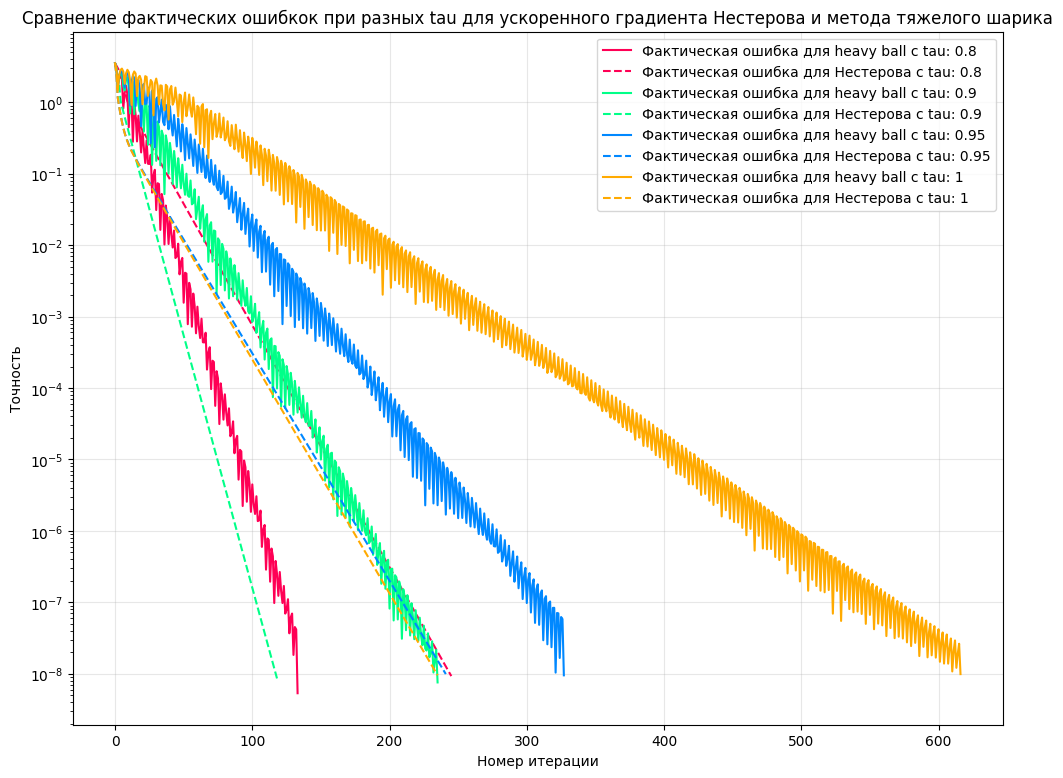

In [ ]:
plot_heavy_ball_vs_nag(errors_hb, errors_nag, tau_coeff, mu, L)

__д) (0.5 балла)__ Наблюдать уменьшение критерия сходимости, конечно, замечательно, но хочется провалидироваться на тестовых данных. Для этого необходимо подсчитать отношение правильно предсказанных меток классов к их общему числу (метрика _accuracy_). Предложите способ, как оценить значение этой метрики. Помните, что функция $g(x, a_i)$ возвращает значение в диапазоне от 0 до 1.

**Решение:** будем оценивать класс по принципу - если b_predict < 0.5, тогда 0, иначе 1

Возьмем оптимальные параметры, найденные в пунктах выше.

In [ ]:
x_k_gd, val_gd, _ = gradient_descent(A_test, b_test, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_functions["2/μ+L"])
x_k_hb, val_hb, _ = heavy_ball(A_test, b_test, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_functions["2/μ+L"], tau=tau_functions["k/k + 20"])
x_k_nag, val_nag, _ = NAG(A_test, b_test, 1/L, grad, criterion, x_0, eps_criterion, max_iter, gamma=gamma_functions["2/μ+L"], tau=tau_functions["k/k + 20"])

100%|██████████| 1000/1000 [00:02<00:00, 493.32it/s]


In [ ]:
def get_accuracy(A, x):
  return (sigmoid(A @ x) >= 0.5).astype(float)

In [ ]:
gd_pred = get_accuracy(A_test, x_k_gd)
hb_pred = get_accuracy(A_test, x_k_hb)
nag_pred = get_accuracy(A_test, x_k_nag)

accuracies = [accuracy_score(b_test, gd_pred), accuracy_score(b_test, hb_pred), accuracy_score(b_test, nag_pred)]
history = [val_gd, val_hb, val_nag]

print(f"Accuracy при градиентном спуске с оптимальными параметрами: {accuracies[0]}")
print(f"Accuracy при методе тяжелого шарика с оптимальными параметрами: {accuracies[1]}")
print(f"Accuracy при градиенте Нестерова с оптимальными параметрами: {accuracies[2]}")

Accuracy при градиентном спуске с оптимальными параметрами: 0.8953846153846153
Accuracy при методе тяжелого шарика с оптимальными параметрами: 0.8953846153846153
Accuracy при градиенте Нестерова с оптимальными параметрами: 0.9458461538461539


__е) (1 балл)__ Постройте графики значения метрики _accuracy_ для градиентного спуска, метода тяжёлого шарика и ускоренного градиентного спуска. Положите шаг равным $\frac{1}{L}$, а значение моментума подберите для каждого метода таким, на котором наблюдалась лучшая сходимость.

In [ ]:
def plot_accuracy(x_vals, mu, L):
    plt.figure(figsize=(12, 9))
    colors = ['#FF0055', '#00FF88', '#0088FF', '#FFAA00']
    labels = ['Градиентный спуск', 'Heavy Ball', 'Нестеров']

    for x_val, color, label in zip(x_vals, colors, labels):
      accuracy_history = []
      for x in range(0, len(x_val), 10):
        pred = (sigmoid(A_test @ x_val[x]) >= 0.5).astype(float)
        acc = accuracy_score(b_test, pred)
        accuracy_history.append(acc)
      plt.plot([i * 10 for i in range(len(accuracy_history))], accuracy_history, color=color, label=label)

    # for x_val, col, lab in zip(x_vals, colors, labels):
    #   acc = get_accuracy(A_test, x_val)
    #   plt.plot(range(len(acc)), acc, color=col, label=lab)
    plt.xlabel('Номер итерации')
    plt.ylabel('Accuracy')
    plt.title('Сравнение accuracy для Gradient Descent, Heavy Ball и Nesterov')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(0, 150)
    plt.show()

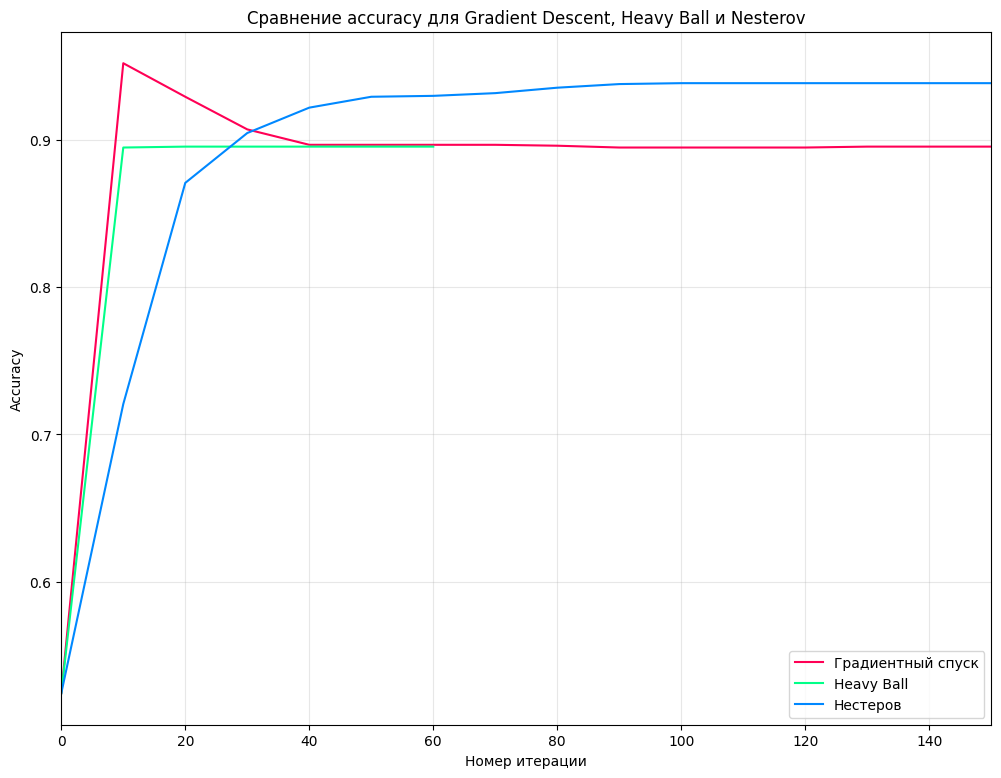

In [ ]:
plot_accuracy(history, mu, L)

**Выводы:** все три метода с оптимальными параметрами показывают хорошую точность предсказаний (в районе 0.9)

## Дополнительная часть (10 баллов)

__Задача 3.__ До этого, в рамках метода градиентного спуска, мы использовали константный и зависящий от номера итерации шаг. В случае неоптимального подбора, алгоритм может требовать сильно большее число итераций для достижения сходимости. Отсюда возникает идея использовать шаги, которые бы зависели от некоторых параметров функции.

Сделаем так: будем искать такой шаг $\gamma_k$ в точке $x^k$, чтобы значение функции в следующей точке было достаточно малым (относительно текущей точки). В идеале, мы хотим решить следующее:

$$
\gamma_k = \arg \min_{\gamma_k} f \left(x^k + \gamma_k p^k \right),~ \text{где $p^k$ — это направление куда мы хотим двигаться.}
$$

Этот алгоритм в общем виде называется _линейный поиск_. Для градиентного спуска $p^k$ — это просто антиградиент.

Как нетрудно заметить, основная проблема заключается в том, что отрешивать $\arg \min$ на каждой итерации спуска — вычислительно сложная задача, которая хоть и даст улучшение по числу итераций, но сильно повысит временные затраты алгоритма. В данной задаче мы изучим различные методы поиска $\gamma_k$, которые начинают с некоторого стартового шага $\gamma_0$ и уменьшают его до тех пор, пока не выполнится необходимое условие приемлемости шага.

__а) (2 балла)__ Первым рассмотрим условие Армихо. Эта стратегия основывается на следующей идее: мы хотим из точки $x^k$ попасть в такую точку $x^{k+1}$, что значение функции в ней достаточно мало по сравнению со значением функции в текущей точке. Но под "достаточно мало" мы понимаем не просто уменьшение, а уменьшение с определённой скоростью, соответствующей направлению спуска. Чтобы это количественно формализовать, будем сравнивать значение функции в новой точке с значением касательной прямой, проведённой в точке $x^k$ в направлении $h^k$. Если новая точка оказывается ниже этой прямой — шаг подходит. Для надёжности наклон касательной немного уменьшают, домножая на коэффициент $c_1 \in (0, 1)$, чтобы не требовать слишком сильного убывания и избежать отбрасывания хороших шагов.

Из вышесказанного получается следующее условие:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f(x^k), h^k \rangle.
$$

Это неравенство можно получить, записав линейное приближение функции $f\left(x^k + \gamma_k h^k \right)$ до первого порядка разложения в точке $x^k$, и затем требуя, чтобы значение функции не просто уменьшилось, а оказалось ниже этого приближения с некоторым запасом.

В случае градиентного спуска $h^k = -\nabla f\left(x^k\right)$ неравенство принимает вид:

$$
f\left(x^k - \gamma_k \nabla f\left( x^k \right)\right) \leq f\left(x^k\right) - \beta_1 \gamma_k \left\| \nabla f\left(x^k\right) \right\|_2^2.
$$

Для удобства, допишите общий метод `gradient_descent_optimal_steps`, который будет принимать в себя различные правила поисков шага (`line_search`), а также напишите функцию `armijo`, вычисляющее приближенное значение $\gamma_k$ за определенное количество итераций.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметр $\beta_1 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f(x^k), h^k \rangle
$$

2. Если условие выполнено — вернуть $\gamma_k$. Иначе — уменьшить шаг:

    $$
    \gamma_k = m \cdot \gamma_k
    $$

    и вернуться к 1.

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def gradient_descent_optimal_steps(A, b, lambda_value, loss, grad, line_search, criterion, x_0, eps=1e-8,
                                   max_iter=1000, **params):
    """
    Реализация градиентного спуска с оптимальным подбором шага.

    Параметры:
        A (np.array): Матрица признаков размерности
        b (np.array): Вектор целевых значений размерности
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь
        grad (Callable): Функция вычисления градиента
        line_search (Callable): Функция подбора шага
        criterion (Callable): Функция критерия остановки
        x_0 (np.array): Начальная точка оптимизации
        eps (float): Точность сходимости (критерий остановки)
        max_iter (int): Максимальное количество итераций
        params (dict): Дополнительные параметры для line_search:
            params['beta1'] (float): Первый параметр (обычное 1e-4)
            params['beta2'] (float): Второй параметр (не используется в правиле Армихо)
            params['gamma_mult'] (float): Множитель для уменьшения шага (обычно 0.5)
            params['line_search_max_iter'] (int): Макс. итераций подбора шага (обычно 100)
            params['gamma0'] (float): Начальное значение шага (обычно 1e-2)

    Возвращает:
        x_k (np.array): Найденное решение
        values (list): История значений x на каждой итерации
        errors (list): История значений критерия сходимости
    """
    values = []
    errors = []

    x_k = np.copy(x_0)
    values.append(x_k)
    errors.append(criterion(x_k, A, b, lambda_value))

    for k in tqdm(range(max_iter)):
        gradient = grad(x_k, A, b, lambda_value)
        step = line_search(A, b,lambda_value, loss, grad, x_k, -gradient,
                           beta1=params['beta1'],
                           beta2=params['beta2'],
                           gamma_mult=params['gamma_mult'],
                           max_iters=params['line_search_max_iter'],
                           gamma0=params['gamma0'])

        x_k = x_k - step * gradient
        values.append(x_k)
        errors.append(criterion(x_k, A, b, lambda_value))
        if errors[-1] < eps:
            break

    return x_k, values, errors

In [ ]:
def armijo(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Армихо.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Армихо
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:
      counter += 1
      new_loss = loss(x + gamma * h, A, b, lambda_value)
      if new_loss <= current_loss + beta1 * gamma * directional_derivative:
        return gamma
      gamma *= gamma_mult

    return gamma

Запустите градиентный спуск с правилом Армихо, рассмотрев разные значения для начальной инициализации $\gamma_0$ и базовыми значениями для других параметров:
- $\gamma_0 = 10^{-2}$ — стандартное значение;
- $\gamma_0 = 10^{-1}$;
- $\gamma_0 = 1$;
- $\gamma_0 = 5$.
- $\gamma_0 = 10$.
- $\gamma_0 = 15$.

В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметра $\beta_1$ возьмите $\beta_1 = 10^{-4}$.

In [ ]:
gammas_coeff = [1e-2, 1e-1, 1, 5, 10, 15]
gamma_mult = 0.5
beta1 = 1e-4
line_search_max_iter = 1000

In [ ]:
errors_armijo = []
for gam in gammas_coeff:
  _, _, error =  gradient_descent_optimal_steps(A_train, b_train, lambda_val, loss, grad, armijo, criterion, x_0, eps=1e-8,
                                   max_iter=1000, beta1=beta1, beta2=0, gamma_mult=gamma_mult, line_search_max_iter=line_search_max_iter, gamma0=gam)
  errors_armijo.append(error)


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-2388429868.py:30: RuntimeWarning: divide by zero encountered in log
  loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
/tmp/ipython-input-2388429868.py:30: RuntimeWarning: invalid value encountered in multiply
  loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
 65%|██████▌   | 654/1000 [00:25<00:13, 26.03it/s]


In [ ]:
def plot_armijo_grad_descend(errors_armijo, gammas_coeff):
  plt.figure(figsize=(12, 9))
  for err, coeff in zip(errors_armijo, gammas_coeff):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для gamma: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных gamma для градиентного спуска с шагом Армихо')
  plt.grid(True, alpha=0.3)
  plt.legend()

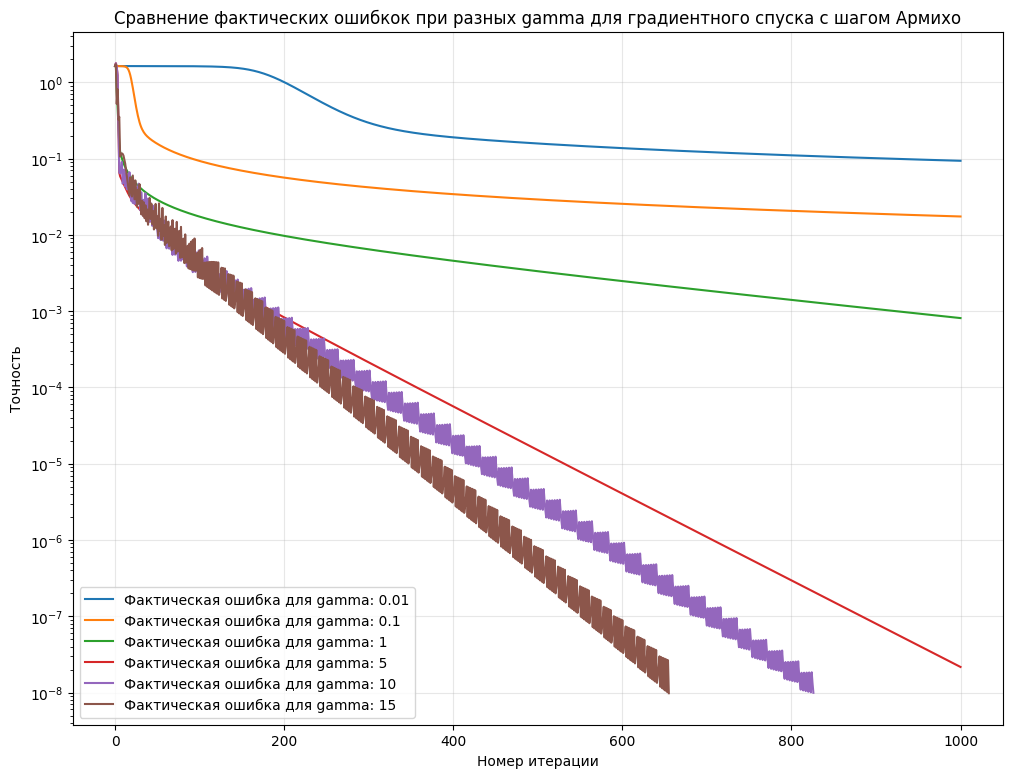

In [ ]:
plot_armijo_grad_descend(errors_armijo, gammas_coeff)

Почему наблюдается худшая сходимость при меньших значений $\gamma_0$?

$\gamma_0$ отвечает за угол наклона касательной, ниже которой мы ищем подходящую новую точку. Если значения довольно маленькие, угол наклона меньше, следовательно под критерии попадают и менее подходящие точки, из-за чего сходимость хуже

__б) (2 балла)__ Хоть правило Армихо и отсекает некоторое количество неудачных шагов, всё же оно не определяет шаг строго — остаётся достаточно широкий выбор допустимых значений $\gamma$, удовлетворяющих неравенству. Это может привести к выбору слишком малого шага, особенно если взять $\gamma$ достаточно маленьким с самого начала — тогда условие Армихо будет выполнено, но скорость сходимости существенно снизится. Вы могли убедиться в этом в предыдущем пункте, где даже слишком маленький шаг удовлетворял критерию.

Чтобы избежать этой проблемы, используется _правило Гольдштейна_, которое сужает диапазон допустимых значений $\gamma$, добавляя нижнюю границу на приращение функции. Оно использует ту же линейную аппроксимацию, но требует, чтобы значение функции не было слишком маленьким — то есть, чтобы шаг не оказался чересчур осторожным. Условие Гольдштейна выглядит следующим образом:

$$
f\left(x^k\right) + \beta_2 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle \leq f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle,
$$

где $0 < \beta_1 < \beta_2 < 1$. Таким образом, выбираются такие $\gamma$, которые дают достаточное, но не чрезмерное убывание функции. Это может значительно ускорить сходимость, особенно на начальных этапах, когда длина шага критична для быстрого продвижения к минимуму.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Гольдштейна:

$$
f\left(x^k\right) + \beta_2 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle \leq f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Если условие выполнено — вернуть $\gamma_k$. Иначе — уменьшить шаг:

    $$
    \gamma_k = m \cdot \gamma_k
    $$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def goldstein(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Гольдштейна.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Гольдштейна
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)

    while counter < max_iters:
      counter += 1
      new_loss = loss(x + gamma * h, A, b, lambda_value)
      if current_loss + beta2 * gamma * directional_derivative <= new_loss <= current_loss + beta1 * gamma * directional_derivative:
        return gamma
      gamma *= gamma_mult

    return gamma

Запустите правило Гольдштейна с параметрами $\gamma_0$ из __а)__. В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметров $\beta_1$ и $\beta_2$ возьмите $\beta_1 = 10^{-4}$ и $\beta_2 = 1 - 10^{-4}$.

In [ ]:
beta1 = 1e-4
beta2 = 1 - 1e-4

In [ ]:
errors_goldstein = []
for gam in gammas_coeff:
  _, _, error =  gradient_descent_optimal_steps(A_train, b_train, lambda_val, loss, grad, goldstein, criterion, x_0, eps=1e-8,
                                   max_iter=1000, beta1=beta1, beta2=beta2, gamma_mult=gamma_mult, line_search_max_iter=line_search_max_iter, gamma0=gam)
  errors_goldstein.append(error)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-2388429868.py:30: RuntimeWarning: divide by zero encountered in log
  loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
/tmp/ipython-input-2388429868.py:30: RuntimeWarning: invalid value encountered in multiply
  loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
 65%|██████▌   | 654/1000 [00:24<00:12, 27.20it/s]


In [ ]:
def plot_goldenstein_grad_descend(errors_goldstein, gammas_coeff):
  plt.figure(figsize=(12, 9))
  for err, coeff in zip(errors_goldstein, gammas_coeff):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для gamma: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных gamma для градиентного спуска с шагом Гольденштейна')
  plt.grid(True, alpha=0.3)
  plt.legend()

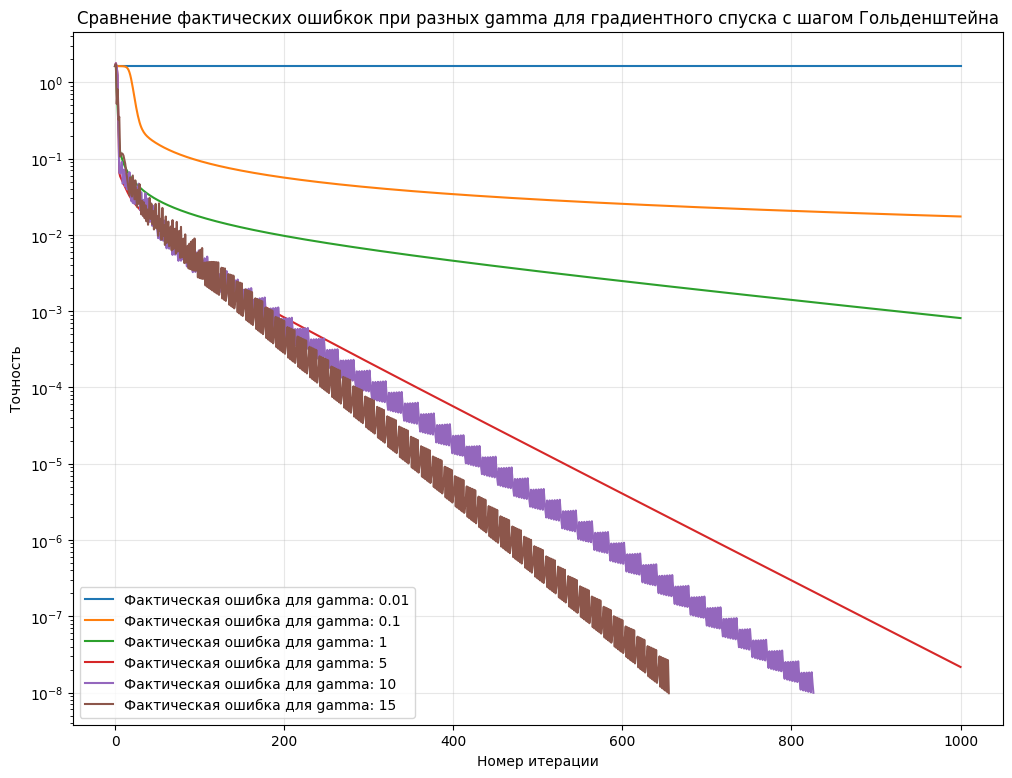

In [ ]:
plot_goldenstein_grad_descend(errors_goldstein, gammas_coeff)

Есть ли улучшение сходимости? Объясните, почему.

Заметных улучшений сходимости (в отличие от шага Армихо) не наблюдается. Это вызвано тем, что правило Гольдштейна сужает диапазон допустимых значений  γ , добавляя нижнюю границу на приращение функции. Оно использует ту же линейную аппроксимацию, но требует, чтобы значение функции не было слишком маленьким — то есть, чтобы шаг не оказался чересчур осторожным.

beta2 очень близка к единице, т.е. по сути мы ограничиваем снизу $f\left(x^k\right) + \beta_2 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle [примерно равно]f\left(x^k\right) + \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle$.

 Наши шаги исходно не были "осторожными". Такая оценка снизу не сильно что-то изменит.

__в) (2 балла)__ Условие Гольдштейна реализует наивное отсечение. Теперь рассмотрим точки, в которых наша функция не убывает так сильно, как в текущей. Конкретнее, нас интересуют такие значения шага, при которых производная по направлению $h^k$ не уменьшилась сильно по сравнению с тем, что было в начале, то есть:

$$
\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle \geq \beta_2 \langle \nabla f \left(x^k\right), h^k \rangle.
$$

Это условие называется условием кривизны (curvature condition). Его смысл — убедиться, что градиент в новой точке не стал слишком плоским по направлению $h^k$, то есть мы не зашли слишком далеко в область, где функция уже почти не меняется. Такое поведение может привести к медленной сходимости и ухудшению качества шага.

Правило Вольфа объединяет два требования: условие Армихо, которое гарантирует достаточное убывание функции, и условие кривизны, которое ограничивает чрезмерное затухание производной. Таким образом, шаг выбирается только в том случае, если оба этих условия выполняются одновременно.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Проверить условие кривизны

$$
\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle \geq \beta_2 \langle \nabla f \left(x^k\right), h^k \rangle
$$

2. Если оба условия выполняются, вернуть $\gamma_k$. Если не выполняется Армихо — уменьшить шаг:

    $$\gamma_k = \gamma_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\gamma_k = \gamma_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def wolfe(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Гольдштейна
    """
    gamma = gamma0
    counter = 0
    f_x = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)
    while counter < max_iters:
        counter += 1
        f_x_new = loss(x + gamma * h, A, b, lambda_value)
        grad_x_new = grad(x + gamma * h, A, b, lambda_value)
        new_directional_derivative = grad_x_new.dot(h)

        if not (f_x_new <= f_x + beta1 * gamma * directional_derivative):
           gamma *= gamma_mult
           continue
        if not (new_directional_derivative >= beta2 * directional_derivative):
           gamma /= gamma_mult
           continue
        return gamma
    return gamma

Запустите правило Вольфа с параметрами $\gamma_0$ из __а)__. В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметров $\beta_1$ и $\beta_2$ возьмите $\beta_1 = 10^{-4}$ и $\beta_2 = 0.9$.

In [ ]:
beta1 = 1e-4
beta2 = 0.9

In [ ]:
errors_wolfe = []
for gam in gammas_coeff:
  _, _, error =  gradient_descent_optimal_steps(A_train, b_train, lambda_val, loss, grad, wolfe, criterion, x_0, eps=1e-8,
                                   max_iter=1000, beta1=beta1, beta2=beta2, gamma_mult=gamma_mult, line_search_max_iter=line_search_max_iter, gamma0=gam)
  errors_wolfe.append(error)

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-2388429868.py:30: RuntimeWarning: divide by zero encountered in log
  loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
/tmp/ipython-input-2388429868.py:30: RuntimeWarning: invalid value encountered in multiply
  loss_val = -np.sum(b * np.log(sigm) + (1 - b) * np.log(1 - sigm)) / n
 65%|██████▌   | 654/1000 [00:37<00:19, 17.53it/s]


In [ ]:
def plot_wolfe_grad_descend(errors_wolfe, gammas_coeff):
  plt.figure(figsize=(12, 9))
  for err, coeff in zip(errors_wolfe, gammas_coeff):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для gamma: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных gamma для градиентного спуска с шагом Вольфа')
  plt.grid(True, alpha=0.3)
  plt.legend()

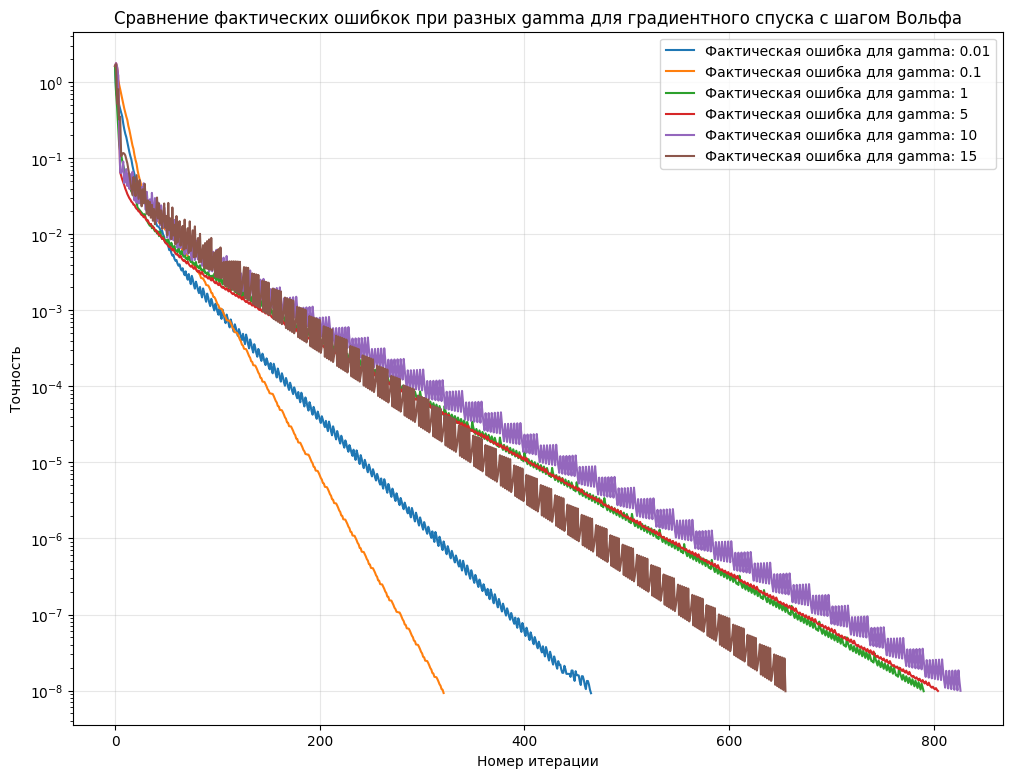

In [ ]:
plot_wolfe_grad_descend(errors_wolfe, gammas_coeff)

__г) (2 балла)__ Обычное условие кривизны может допускать ситуацию, когда производная по направлению в новой точке становится положительной, что приводит к тому, что неравенство всегда выполняется. Чтобы исключить этот случай, можно использовать модули для проверки абсолютного значения градиента:

$$
|\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle| \leq \beta_2 |\langle \nabla f \left(x^k\right), h^k \rangle|.
$$

Знак меняется, потому что справа мы имеем отрицательное значение, которое становится положительным. Мы хотим, чтобы абсолютное значение производной в новой точке было близким к нулю, так как в оптимуме градиент должен быть равен нулю, а это гарантирует, что шаг был выбран правильно и направлен в сторону минимума.

**Псевдокод алгоритма**

---

_Инициализация:_

- Начальная точка $x^k$
- Начальная точка $\gamma_0 > 0$
- Направление спуска $h^k$
- Максимальное число итераций $K$
- Множитель уменьшения шага $m \in (0, 1)$
- Параметры $\beta_1, \beta_2 \in (0, 1)$

---

1. Проверить условие Армихо:

$$
f\left(x^k + \gamma_k h^k\right) \leq f\left(x^k\right) + \beta_1 \gamma_k \langle \nabla f\left(x^k\right), h^k \rangle
$$

2. Проверить сильное условие кривизны

$$
|\langle \nabla f \left(x^k + \gamma_k h^k\right),  h^k \rangle| \leq \beta_2 |\langle \nabla f \left(x^k\right), h^k \rangle|
$$

2. Если оба условия выполняются, вернуть $\gamma_k$. Если не выполняется Армихо или направление положительное — уменьшить шаг:

    $$\gamma_k = \gamma_k \cdot m$$

    и вернуться к 1. Иначе — увеличить шаг:

    $$\gamma_k = \gamma_k / m$$

    и вернуться к 1

---

_Условие остановки:_
- Достигнуто максимальное число итераций $K$

---

_Выход:_
- Полученное значение $\gamma_k$

In [ ]:
def strong_wolfe(A, b, lambda_value, loss, grad, x, h, beta1, beta2, gamma_mult, max_iters, gamma0):
    """
    Сильное правило Вольфа.

    Параметры:
        A (np.array): Матрица признаков
        b (np.array): Вектор целевых значений
        lambda_value (float): Параметр регуляризации
        loss (Callable): Функция потерь f(x)
        grad (Callable): Функция вычисления градиента ∇f(x)
        x (np.array): Текущая точка
        h (np.array): Направление спуска (обычно -∇f(x))
        beta1 (float): Параметр условия достаточного убывания (обычно 1e-4)
        beta2 (float): Не используется, оставлен для совместимости, по умолчанию 0
        gamma_mult (float): Множитель уменьшения шага (обычно 0.5)
        max_iters (int): Максимальное число итераций подбора (обычно 100)
        gamma0 (float): Начальное значение шага

    Возвращает:
        gamma (float): Найденное значение шага, удовлетворяющее условию Гольдштейна
    """
    gamma = gamma0
    counter = 0
    current_loss = loss(x, A, b, lambda_value)
    grad_x = grad(x, A, b, lambda_value)
    directional_derivative = grad_x.dot(h)
    while counter < max_iters:
      counter += 1;
      new_loss = loss(x + gamma * h, A, b, lambda_value)
      new_grad_x = grad(x + gamma * h, A, b, lambda_value)
      new_directional_derivative = new_grad_x.dot(h)
      if not (new_loss <= current_loss + beta1 * gamma * directional_derivative) or new_directional_derivative > 0:
        gamma *= gamma_mult
        continue
      if not (abs(new_directional_derivative) <= abs(beta2 * directional_derivative)):
        gamma /= gamma_mult
        continue
      return gamma
    return gamma

Запустите правило усиленного Вольфа с параметрами $\gamma_0$ из __а)__. В качестве множителя уменьшения шага рассмотрите $m = 0.5$. В качестве параметров $\beta_1$ и $\beta_2$ возьмите $\beta_1 = 10^{-4}$ и $\beta_2 = 0.9$.

In [ ]:
errors_strong_wolfe = []
for gam in gammas_coeff:
  _, _, error =  gradient_descent_optimal_steps(A_train, b_train, lambda_val, loss, grad, strong_wolfe, criterion, x_0, eps=1e-8,
                                   max_iter=1000, beta1=beta1, beta2=beta2, gamma_mult=gamma_mult, line_search_max_iter=line_search_max_iter, gamma0=gam)
  errors_strong_wolfe.append(error)

 59%|█████▉    | 593/1000 [00:32<00:22, 18.10it/s]


In [ ]:
def plot_strong_wolfe_grad_descend(errors_strong_wolfe, gammas_coeff):
  plt.figure(figsize=(12, 9))
  for err, coeff in zip(errors_strong_wolfe, gammas_coeff):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для gamma: {coeff}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных gamma для градиентного спуска с усиленным шагом Вольфа')
  plt.grid(True, alpha=0.3)
  plt.legend()

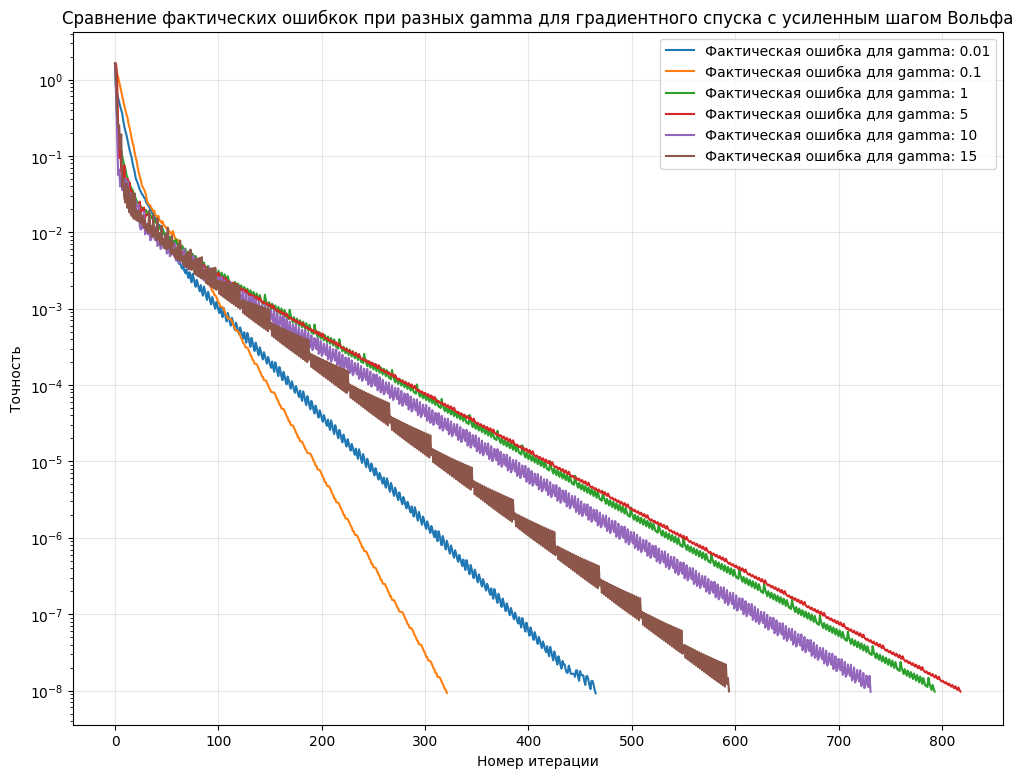

In [ ]:
plot_strong_wolfe_grad_descend(errors_strong_wolfe, gammas_coeff)

__д) (2 балла)__ Сделайте итоговое сравнение методов. Постройте график и укажите, какой оказался наиболее эффективным, для следующих методов: градиентный спуск с лучшим шагом, ускоренный градиентный метод с оптимальными параметрами или градиентный спуск с адаптивным шагом (Армихо, Гольдштейн, Вольф или усиленный Вольф).

In [ ]:
best_errors_gd = errors_gd[1]
best_errors_upd_gd = errors_nag[1]
best_errors_armijo = errors_armijo[-1]
best_errors_goldstein = errors_goldstein[-1]
best_errors_wolfe = errors_wolfe[1]
best_errors_strong_wolfe = errors_strong_wolfe[1]

titles = ["Град спуск с шагом 1/L", "Усиленный град спуск Нестерова с шагом 1/L и 0.9tau",
          "Град спуск с шагом Армихо gamma=15", "Град спуск с шагом Гольдштейна gamma=15",
          "Град спуск с шагом Вольфа gamma=0.1", "Град спуск с усиленным шагом Вольфа gamma=0.1"]

errors_all = [best_errors_gd, best_errors_upd_gd, best_errors_armijo, best_errors_goldstein,
              best_errors_wolfe, best_errors_strong_wolfe]

In [ ]:
def plot_best(errors_all, titles):
  plt.figure(figsize=(12, 9))
  for err, title in zip(errors_all, titles):
    plt.semilogy(range(len(err)), err, label=f'Фактическая ошибка для: {title}')
  plt.xlabel('Номер итерации')
  plt.ylabel('Точность')
  plt.title('Сравнение фактических ошибкок при разных методах с оптимальными параметрами')
  plt.grid(True, alpha=0.3)
  plt.legend()

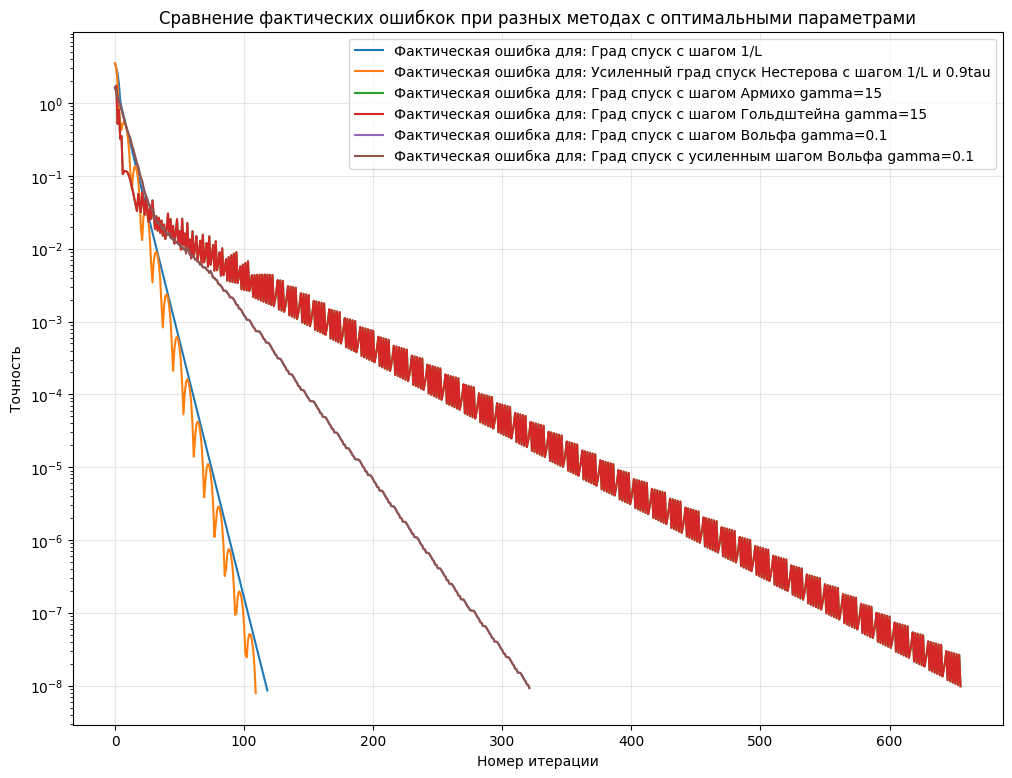

In [ ]:
plot_best(errors_all, titles)

**Вывод:** среди всех исследуемых моделей с оптимальными параметрами лучше всех сошелся Нестеров